# Extraction des données de la BDD GazeFollow

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

In [3]:
data_path= "/content/drive/MyDrive/MLA_Projet/GazeFollow/data/data_new"

### Extraction of the matrix

In [4]:
mat_fname_test = pjoin(data_path, 'test_annotations.mat')
mat_contents_test = sio.loadmat(mat_fname_test)
#print(mat_contents_test)
#sorted(mat_contents_test.keys())

mat_fname_train = pjoin(data_path, 'train_annotations.mat')
mat_contents_train = sio.loadmat(mat_fname_train)
#print(mat_contents_train)
#sorted(mat_contents_train.keys())

In [5]:
"""#order of image
i=1

im_eye = mat_contents_test['test_eyes'][0][i]
im_path1= mat_contents_test['test_path'][i][0][0]
im_path = pjoin(data_path, im_path1)
im= cv2.imread(im_path)
image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
e= (im.shape[1], im.shape[0])*im_eye
im_gaze = mat_contents_test['test_gaze'][0][i]
g= (im.shape[1], im.shape[0])*im_gaze
im_box= mat_contents_test['test_bbox'][0][i]

plt.imshow(im)
plt.show()
print(im.shape)
"""

"#order of image\ni=1\n\nim_eye = mat_contents_test['test_eyes'][0][i]\nim_path1= mat_contents_test['test_path'][i][0][0]\nim_path = pjoin(data_path, im_path1)\nim= cv2.imread(im_path)\nimage = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)\ne= (im.shape[1], im.shape[0])*im_eye\nim_gaze = mat_contents_test['test_gaze'][0][i]\ng= (im.shape[1], im.shape[0])*im_gaze\nim_box= mat_contents_test['test_bbox'][0][i]\n\nplt.imshow(im)\nplt.show()\nprint(im.shape)\n"

In [6]:
"""def box(im_box,im):
    width,height,_= im.shape
    box= (height, width,height/2, width/2)*im_box[0,:]
    box=box -np.array([0,0,box[0]/2,box[1]/2])
    #w=im_box[0,2]*width- box[1]
    #h=im_box[0,3]*height-box[0]
    return box[:2],box[2],box[3]

rec = box(im_box,im)
rec"""

'def box(im_box,im):\n    width,height,_= im.shape\n    box= (height, width,height/2, width/2)*im_box[0,:]\n    box=box -np.array([0,0,box[0]/2,box[1]/2])\n    #w=im_box[0,2]*width- box[1]\n    #h=im_box[0,3]*height-box[0]\n    return box[:2],box[2],box[3]\n\nrec = box(im_box,im)\nrec'

In [7]:
"""# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle(rec[0],rec[2],rec[1], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

print(rect)

plt.scatter(real_pts[0], real_pts[1],color='r')"""

"# Create figure and axes\nfig, ax = plt.subplots()\n\n# Display the image\nax.imshow(im)\n\n# Create a Rectangle patch\nrect = patches.Rectangle(rec[0],rec[2],rec[1], linewidth=1, edgecolor='r', facecolor='none')\n\n# Add the patch to the Axes\nax.add_patch(rect)\n\nprint(rect)\n\nplt.scatter(real_pts[0], real_pts[1],color='r')"

In [8]:
def dataset_extractor_test(data_path, matrix_contents_dataset):

    images = []
    gazes = []

    for i in range(len(matrix_contents_dataset['test_gaze'][0])):
        
        ########### Image part ############
        pic_path = matrix_contents_dataset['test_path'][i][0][0]
        pic = cv2.imread(pjoin(data_path, pic_path))
        images.append(pic)

        ########### Gaze part #############
        gaze_i = matrix_contents_dataset['test_gaze'][0][i]
        mean_pts = np.mean(gaze_i, axis=0)
        real_pts = mean_pts*(64, 64)
        #creation of a picture with 0 everywhere and 1 on the gaze point
        target = np.zeros((64, 64))
        target[int(real_pts[0]), int(real_pts[1])] = 255
        gazes.append(target)

    return images , gazes

"""def dataset_extractor_train(data_path, matrix_contents_dataset_train):

    images = []
    gazes = []

    for i in range(len(matrix_contents_dataset_train['train_gaze'][0])*0.5):
        
        ########### Image part ############
        pic_path = matrix_contents_dataset_train['train_path'][i][0][0]
        pic = cv2.imread(pjoin(data_path, pic_path))
        images.append(pic)

        ########### Gaze part #############
        gaze_i = matrix_contents_dataset_train['train_gaze'][0][i]
        mean_pts = np.mean(gaze_i, axis=0)
        real_pts = mean_pts*(64, 64)
        #creation of a picture with 0 everywhere and 1 on the gaze point
        target = np.zeros((64, 64))
        target[int(real_pts[0]), int(real_pts[1])] = 255
        gazes.append(target)

    return images, gazes
"""

"def dataset_extractor_train(data_path, matrix_contents_dataset_train):\n\n    images = []\n    gazes = []\n\n    for i in range(len(matrix_contents_dataset_train['train_gaze'][0])*0.5):\n        \n        ########### Image part ############\n        pic_path = matrix_contents_dataset_train['train_path'][i][0][0]\n        pic = cv2.imread(pjoin(data_path, pic_path))\n        images.append(pic)\n\n        ########### Gaze part #############\n        gaze_i = matrix_contents_dataset_train['train_gaze'][0][i]\n        mean_pts = np.mean(gaze_i, axis=0)\n        real_pts = mean_pts*(64, 64)\n        #creation of a picture with 0 everywhere and 1 on the gaze point\n        target = np.zeros((64, 64))\n        target[int(real_pts[0]), int(real_pts[1])] = 255\n        gazes.append(target)\n\n    return images, gazes\n"

In [9]:
images_test , gazes_test   = dataset_extractor_test(data_path, mat_contents_test)
#images_train , gazes_train = dataset_extractor_train(data_path, mat_contents_train)

In [10]:
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [11]:
class GazeFollowDataset(Dataset):

    def __init__(self, data_in, target, transform=None):
        self.data_in   = data_in
        self.target    = target
        self.transform = transform

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        x = self.data_in[idx]
        y = self.target[idx]

        if self.transform:
              x = self.transform(x)
        #sample = {'input': x, 'box': y}

        return x, y

In [12]:
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

In [13]:
data_test  = GazeFollowDataset(images_test, gazes_test, transform=preprocess)

#DataLoader(data_test, batch_size=nb_image, shuffle=False, num_workers=0)

In [14]:
#from scipy import signal
#def gaussienne_bbox(width, sigma):
    #"""
    #    Génération of the guassian in the center of the bounding box
    #"""
    #gaussienne1d = signal.gaussian(width, std=sigma).reshape(width, 1)
    #return np.outer(gaussienne1d, gaussienne1d)

# Create the backbone

In [15]:
# ResNet50
import torchvision.models as models
backbone = models.resnet50(pretrained=True, progress=True)
print("ResNet50 loaded")
# Freeze the learning of the layers of the resnet50
for param in backbone.parameters():
    param.requires_grad = False


ResNet50 loaded


# Création du modèle "Heatmap Regression Head"

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
import torch
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import time
import warnings

warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [17]:
def concat(p1, p2, axis=0):
    """
        p1, p2 : already tensors
        axis   : 0 for raw, 1 for columns
        
        Concatenation of the two pictures of the entry
    """
    return tf.concat([p1, p2], 0)


[[[0.00022999 0.00022273 0.00027721 ... 0.0002199  0.00028259 0.00022224]
  [0.00025258 0.00021967 0.00028178 ... 0.00022014 0.00028163 0.00022223]
  [0.00025317 0.00021972 0.00028102 ... 0.00021996 0.00028281 0.0002223 ]
  ...
  [0.00025256 0.00021967 0.00028178 ... 0.00021885 0.00028616 0.00022248]
  [0.00025117 0.00021899 0.00028183 ... 0.00022017 0.00028229 0.00022223]
  [0.00025232 0.00021967 0.00028217 ... 0.00021943 0.0002804  0.00024135]]]


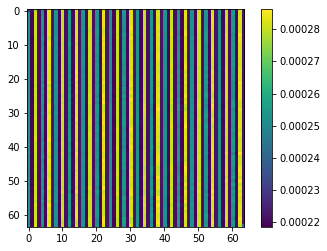

In [18]:
class h_reg(nn.Module):
    def __init__(self):
        super(h_reg, self).__init__()
        
        #Resnet
        self.backbone = backbone
        
        #convolution layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=10, stride=2, padding=6)
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=6)

        # Fully connected layer
        self.downsample1 = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.downsample2 = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        self.downsample3 = nn.ConvTranspose1d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        
        
    # x represents our data
    def forward(self, x):

        x = self.backbone(x)
       
        x = x.unsqueeze(dim=1) 
        x = self.conv1(x)
        x = self.conv2(x)
        
        x = self.downsample1(x)
        x = self.downsample2(x)
        x = self.downsample3(x)
        
        x = x.squeeze(dim=1)

        output = F.softmax(x, dim=1)
        output = output.reshape(1, 64, 64)
        
        return output

    
##########################################################
#   Only a simple test on the Heatmap Regression Head    #
##########################################################

# Equates to one random 448x224 image
random_data = torch.rand((1, 3, 224+224, 224))

my_nn = h_reg()
result = my_nn(random_data)

result = result.detach().numpy() 
print(result)

plt.imshow(result[0,:,:])
plt.colorbar()
plt.show()

# Entraînement

In [19]:
def train(model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'):
    
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))


    history             = {} # Collects per-epoch loss and acc like Keras' fit().
    history['loss']     = []
    history['val_loss'] = []
    history['acc']      = []
    history['val_acc']  = []

    start_time_sec = time.time()


    for epoch in range(1, epochs+1):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        model.train()
        train_loss         = 0.0
        num_train_correct  = 0
        num_train_examples = 0

        for batch in train_dl:

            optimizer.zero_grad()

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            loss.backward()
            optimizer.step()

            train_loss         += loss.data.item() * x.size(0)
            num_train_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc   = num_train_correct / num_train_examples
        train_loss  = train_loss / len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss         = 0.0
        num_val_correct  = 0
        num_val_examples = 0

        for batch in val_dl:

            x    = batch[0].to(device)
            y    = batch[1].to(device)
            yhat = model(x)
            loss = loss_fn(yhat, y)

            val_loss         += loss.data.item() * x.size(0)
            num_val_correct  += (torch.max(yhat, 1)[1] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc  = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dl.dataset)


        if epoch == 1 or epoch % 10 == 0:
            print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
            (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

    # END OF TRAINING LOOP

    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    time_per_epoch_sec = total_time_sec / epochs
    print()
    print('Time total:     %5.2f sec' % (total_time_sec))
    print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))

    return history


In [ ]:
# model, optimizer, loss_fn, train_dl, val_dl, epochs=100, device='cpu'
validation_split = .2
batch_size= 128
dataset_size = len(data_test)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)




network           = h_reg()
optimizer         = torch.optim.Adam(network.parameters(), lr = 0.001)
loss_fn           = nn.MSELoss()
epochs            = 9
device            = "cuda"
train_loader      = DataLoader(data_test, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(data_test, batch_size=batch_size, sampler=valid_sampler)

history = train(network, optimizer, loss_fn, train_loader, validation_loader, epochs, device)